# Plotting Interpolation for ControlNet

In [1]:
# Modules
import torch
import torchvision
import torchvision.utils as vutils

import numpy as np

import os

#plotting
import matplotlib.pyplot as plt

from PIL import Image

from torch_geometry.metrics import euclidean_energy

In [30]:
image_type = "eagle"
image_path = "sample_results"
methods = ["ProbGEORCE_D", "ProbGEORCE_N", "linear", "slerp", "noisediffusion", "noise"]
figure_path = f'../figures/'

## Loading Images

In [31]:
def convert_to_torch(img):

    if img.mode == 'RGBA':#
        img = img.convert('RGB')
    img = torch.tensor(np.array(img), dtype=torch.float32).permute(2,0,1).unsqueeze(0)

    return img

In [32]:
img1 = Image.open(f'sample_imgs/{image_type}1.png').resize((768, 768))
img2 = Image.open(f'sample_imgs/{image_type}2.png').resize((768, 768))

In [33]:
img1 = convert_to_torch(img1)
img2 = convert_to_torch(img2)

In [34]:
save_path = ''.join((image_path, f'/{image_type}', '/'))    
onlyfolders = [f for f in os.listdir(save_path) if not os.path.isfile(os.path.join(save_path, f))]

In [35]:
curves = {}
for folder in onlyfolders:
    subpath = ''.join((image_path, f'/{image_type}/{folder}'))
    onlyfiles = [f for f in os.listdir(subpath) if (os.path.isfile(os.path.join(subpath, f)) and "png" in f)]
    j = 0
    vals = []
    while True:
        file = f'{j}.png'
        if file in onlyfiles:
            img = Image.open(''.join((subpath, f'/{file}'))).resize((786,786))
            img = convert_to_torch(img)
            vals.append(img)
        else:
            break
        j += 1
    curves[folder] = torch.stack(vals)

In [36]:
np.sort(onlyfiles)

array(['0.png', '1.png', '10.png', '2.png', '3.png', '4.png', '5.png',
       '6.png', '7.png', '8.png', '9.png'], dtype='<U6')

In [37]:
len(curves)

10

## Plotting

### Full Plot

In [15]:
data_curves = []
for key, val in curves.items():
    data_curves.append(val)
data_curves = torch.stack(data_curves)

torch.Size([132, 3, 786, 786])


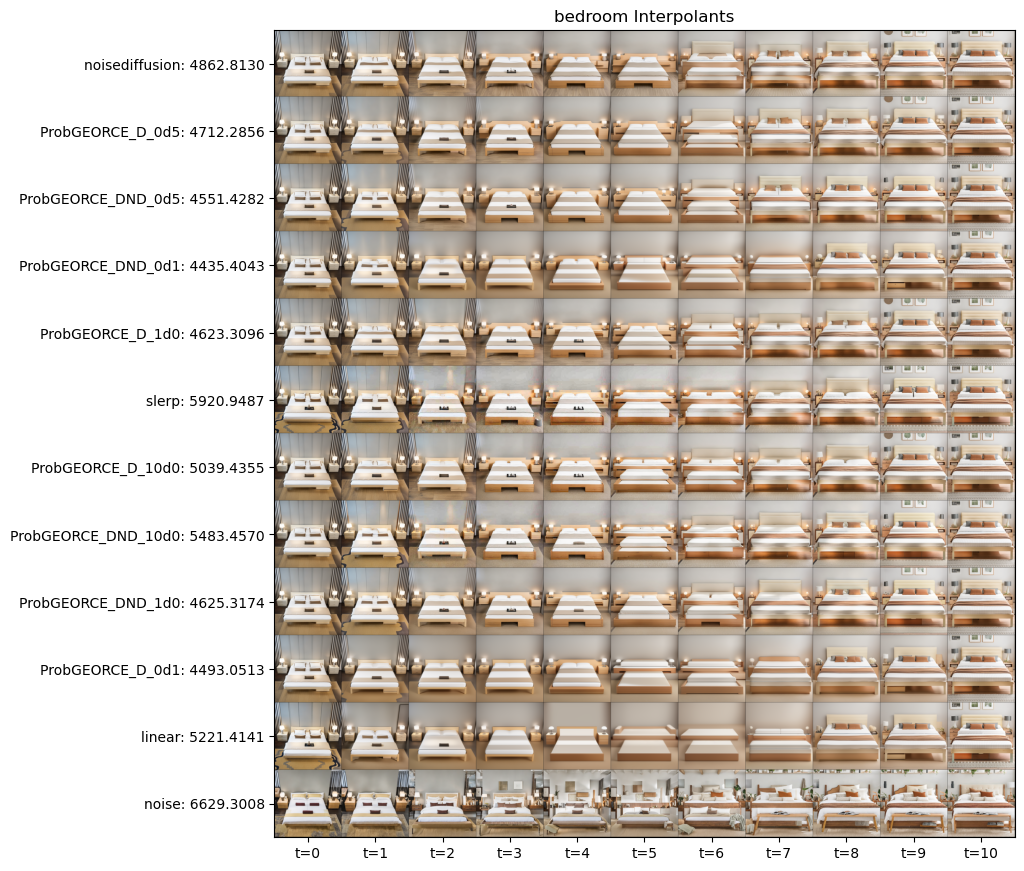

In [16]:
N = 10
plot_grid = N//10
plot_curves = data_curves[:,::plot_grid]

img_height = 786+2
tick_list = [0.5*img_height+j*img_height for j in range(len(data_curves))]
length = [f"{k}: {(euclidean_energy(val)/(768*786*3)):.4f}" for k,val in curves.items()]
tick_xlist = [img_height/2+j*img_height for j in range(11)]
grid_index = [f"t={int(plot_grid*i)}" for i in range(11)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"{image_type} Interpolants")
plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))
print(plot_val.shape)
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}{image_type}_all.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

### Illustration

In [27]:
plot_type = ['ProbGEORCE_D_0d1', 'ProbGEORCE_D_0d5', 'ProbGEORCE_D_1d0', 'ProbGEORCE_D_10d0']

In [28]:
data_curves = []
for p_type in plot_type:
    for key, val in curves.items():
        if key == p_type:
            data_curves.append(val)
data_curves = torch.stack(data_curves)

In [29]:
single_curves = {}
for pt in plot_type:
    for k,v in curves.items():
        if k == pt:
            single_curves[k] = v

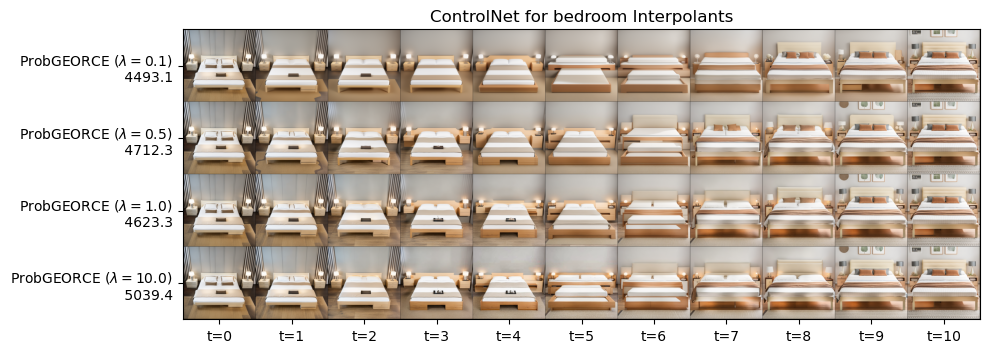

In [30]:
N = 10
plot_grid = N//10
plot_curves = data_curves[:,::plot_grid]

img_height = 786+2
tick_list = [0.5*img_height+j*img_height for j in range(len(data_curves))]
length = [f"{k.replace('_D','').replace('d', '.').replace('_',r' ($\lambda=$')}) \n {(euclidean_energy(val)/(768*786*3)):.1f}" for k,val in single_curves.items()]
tick_xlist = [img_height/2+j*img_height for j in range(11)]
grid_index = [f"t={int(plot_grid*i)}" for i in range(11)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"ControlNet for {image_type} Interpolants")
plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
#ax.axes.get_yaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}{image_type}_lambda.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

## Comparison

In [43]:
plot_type = {'linear': 'Linear', 
             'slerp': 'Spherical', 
             'noise': 'Noise', 
             'noisediffusion': 'NoiseDiffusion',
             'ProbGEORCE_D_0d1': r'ProbGEORCE ($\lambda=0.1$)', 
             'ProbGEORCE_D_0d5': r'ProbGEORCE ($\lambda=0.5$)', 
             'ProbGEORCE_D_1d0': r'ProbGEORCE ($\lambda=1.0$)', 
             'ProbGEORCE_D_10d0': r'ProbGEORCE ($\lambda=10.0$)', 
            }

In [44]:
data_curves = []
for p_type in plot_type.keys():
    for key, val in curves.items():
        if key == p_type:
            data_curves.append(val)
data_curves = torch.stack(data_curves)

In [45]:
single_curves = {}
for pt in plot_type:
    for k,v in curves.items():
        if k == pt:
            single_curves[k] = v

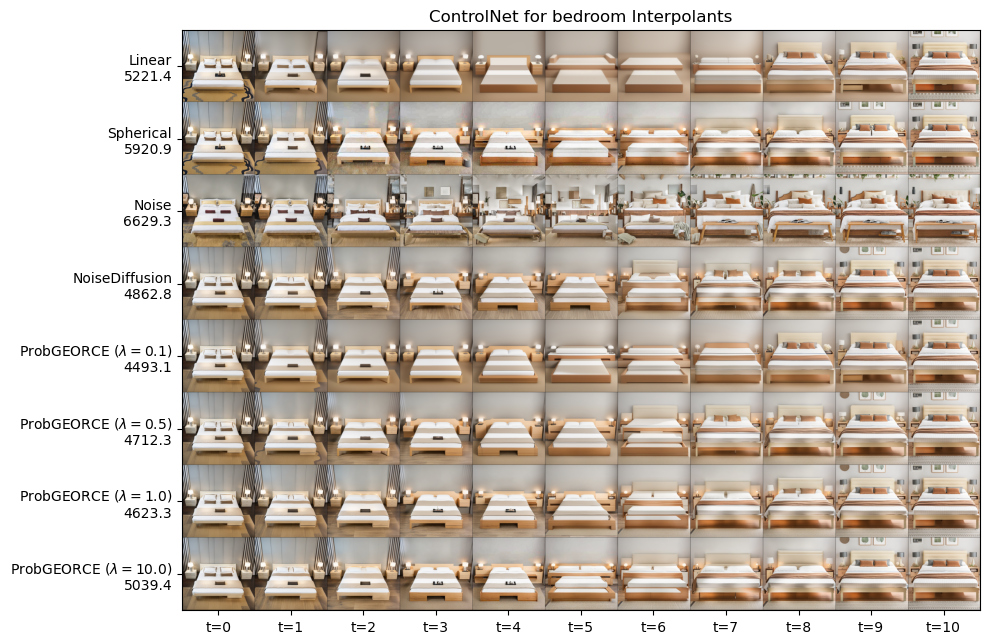

In [48]:
N = 10
plot_grid = N//10
plot_curves = data_curves[:,::plot_grid]

img_height = 786+2
tick_list = [0.5*img_height+j*img_height for j in range(len(data_curves))]
length = [f"{plot_type[k]}\n{(euclidean_energy(val)/(768*786*3)):.1f}" for k,val in single_curves.items()]
tick_xlist = [img_height/2+j*img_height for j in range(11)]
grid_index = [f"t={int(plot_grid*i)}" for i in range(11)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"ControlNet for {image_type} Interpolants")
plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
#ax.axes.get_yaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}{image_type}_comparison.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

## Comparison to Noise Diffusion

In [38]:
plot_type = {'ProbGEORCE_ND_clip_1d0_0d1_0d1': r'ProbGEORCE_ND ($\lambda=1.0$, $\mu=\nu=0.1$)', 
             'ProbGEORCE_ND_clip_1d0_0d5_0d5': r'ProbGEORCE_ND ($\lambda=1.0$, $\mu=\nu=0.5$)', 
             'ProbGEORCE_ND_clip_1d0_1d0_1d0': r'ProbGEORCE_ND ($\lambda=1.0$, $\mu=\nu=1.0$)', 
             'ProbGEORCE_ND_clip_1d0_2d0_2d0': r'ProbGEORCE_ND ($\lambda=1.0$, $\mu=\nu=2.0$)', 
             'ProbGEORCE_ND_clip_1d0_10d0_10d0': r'ProbGEORCE_ND ($\lambda=1.0$, $\mu=\nu=10.0$)', 
             'NoiseDiffusion_clip_0d1_0d1': r'NoiseDiffusion ($\mu=\nu=0.1$)', 
             'NoiseDiffusion_clip_0d5_0d5': r'NoiseDiffusion ($\mu=\nu=0.5$)', 
             'NoiseDiffusion_clip_1d0_1d0': r'NoiseDiffusion ($\mu=\nu=1.0$)', 
             'NoiseDiffusion_clip_2d0_2d0': r'NoiseDiffusion ($\mu=\nu=2.0$)',
             'NoiseDiffusion_clip_10d0_10d0': r'NoiseDiffusion ($\mu=\nu=10.0$)', 
            }

In [39]:
data_curves = []
for p_type in plot_type.keys():
    for key, val in curves.items():
        if key == p_type:
            data_curves.append(val)
data_curves = torch.stack(data_curves)

In [40]:
single_curves = {}
for pt in plot_type:
    for k,v in curves.items():
        if k == pt:
            single_curves[k] = v

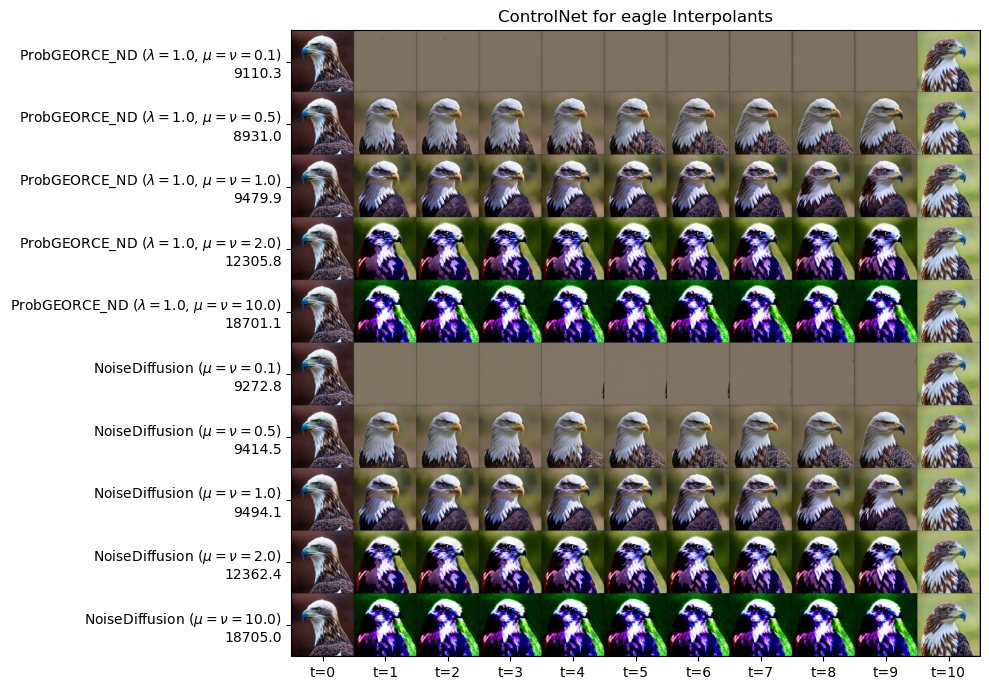

In [41]:
N = 10
plot_grid = N//10
plot_curves = data_curves[:,::plot_grid]

img_height = 786+2
tick_list = [0.5*img_height+j*img_height for j in range(len(data_curves))]
length = [f"{plot_type[k]}\n{(euclidean_energy(val)/(768*786*3)):.1f}" for k,val in single_curves.items()]
tick_xlist = [img_height/2+j*img_height for j in range(11)]
grid_index = [f"t={int(plot_grid*i)}" for i in range(11)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"ControlNet for {image_type} Interpolants")
plot_val = torch.from_numpy(np.array(plot_curves.reshape(-1,3,786,786)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
#ax.axes.get_xaxis().set_visible(False)
#ax.axes.get_yaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)
ax.set_xticks(tick_xlist)
ax.set_xticklabels(grid_index)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}{image_type}_comparison_to_noise_diffusion.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')